- https://geoffboeing.com/2018/07/comparing-city-street-orientations/
- https://doi.org/10.1007/s41109-019-0189-1
- https://github.com/gboeing/osmnx
- https://github.com/russellporter/openskimap.org/issues/82
- groomed v ungroomed
- https://github.com/tilezen/joerd
- trail orientation v aspect
- weight by elevation descent
- max slope v difficulty by region
- https://osmnx.readthedocs.io/en/stable/internals-reference.html-osmnx-bearing-module
- https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long
- https://github.com/gboeing/osmnx/blob/cabdbb246dc14095f5d8e8b8ead38f9649dae2c7/osmnx/bearing.py#L18


In [1]:
import json
import geojson
import pathlib
import math
import plotnine as pn
import polars
from osmnx.bearing import calculate_bearing
from osmnx.plot import plot_orientation
import matplotlib.pyplot as plt

In [2]:
path = pathlib.Path("data/runs.geojson")
with open(path) as read_file:
    runs = json.load(read_file)

In [3]:
list(runs)

['type', 'features']

In [6]:
example_run = runs["features"][0]

In [7]:
ski_area_to_runs = {}
for run in runs["features"]:
    ski_areas = run["properties"]["skiAreas"]
    if len(ski_areas) == 0:
        continue
    ski_area_name = ski_areas[0]["properties"]["name"]
    if not ski_area_name:
        continue
    ski_area_to_runs.setdefault(ski_area_name, []).append(run)

In [8]:
len(ski_area_to_runs)

3921

In [9]:
for x in ski_area_to_runs:
    if "Skiway" in x:
        print(x)

Dartmouth Skiway


In [10]:
# def calculate_bearing(delta_lon, delta_lat):
#     """Calculate the aspect in degrees from north."""
#     angle = math.degrees(math.atan2(delta_lon, delta_lat))
#     # Convert from mathematical angle to compass direction
#     # Must Subtract 90 degrees to align with polar plot orientation
#     aspect = (450 - angle) % 360
#     return aspect

def interpolate_points(start, end, interval_meters):
    """Interpolate points between start and end at given interval in meters."""
    delta_lon = end[0] - start[0]
    delta_lat = end[1] - start[1]
    delta_elevation = end[2] - start[2]
    # Calculate the distance between the points
    distance = math.sqrt(delta_lon**2 + delta_lat**2) * 111319.9  # in meters
    num_intervals = int(distance // interval_meters)
    interpolated_points = []
    for i in range(num_intervals + 1):
        fraction = i / num_intervals
        interpolated_points.append([
            start[0] + fraction * delta_lon,
            start[1] + fraction * delta_lat,
            start[2] + fraction * delta_elevation
        ])
    return interpolated_points

def compute_aspects_every_meter(coordinates, interval_meters=1):
    """Compute the aspect every meter along the ski run."""
    aspects = []
    for i in range(len(coordinates) - 1):
        start = coordinates[i]
        end = coordinates[i + 1]
        # Interpolate points every meter
        interpolated_points = interpolate_points(start, end, interval_meters)
        for j in range(len(interpolated_points) - 1):
            high_point = interpolated_points[j]
            low_point = interpolated_points[j + 1]
            if low_point[2] > high_point[2]:
                high_point, low_point = low_point, high_point
            lat_high, long_high, ele_high = high_point
            lat_low, long_low, ele_low = low_point
            aspect = calculate_bearing(lat1=lat_high, lon1=long_high, lat2=lat_low, lon2=long_low)
            aspects.append(aspect)
    return aspects

In [11]:
# name = "Okemo Mountain"
# name = "Killington Resort"
name = "Dartmouth Skiway"
ski_are_runs = ski_area_to_runs[name]
aspects = []
for run in ski_are_runs:
    coordinates = run["geometry"]["coordinates"]
    aspects.extend(compute_aspects_every_meter(coordinates))

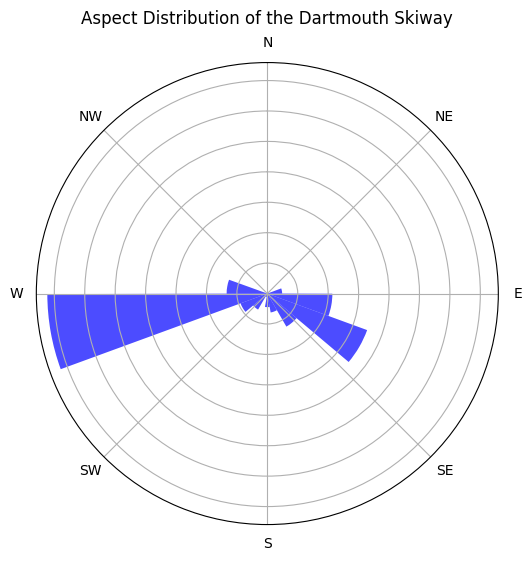

In [12]:
# FIXME use https://github.com/gboeing/osmnx/blob/cabdbb246dc14095f5d8e8b8ead38f9649dae2c7/osmnx/plot.py#L700 instead

# Convert aspects to radians for plotting
aspects_radians = [math.radians(aspect + 90) for aspect in aspects]

# Create a polar plot
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.hist(aspects_radians, bins=18, alpha=0.7, color='blue')

# Set the direction of the zero angle
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Set labels for cardinal directions
ax.set_xticks([math.pi/180 * x for x in range(0,  360, 45)])
ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
ax.set_yticklabels([])

# Set title and labels
ax.set_title(f'Aspect Distribution of the {name}', va='bottom')
plt.show()
